# 파이썬으로 다층 퍼셉트론 구현하는 예제! (리스트 7-1)

In [1]:
#-- 리스트 7-1-(1)
import numpy as np
# 데이터 생성 --------------------------------
np.random.seed(seed=1) # 난수를 고정
N = 200 # 데이터의 수
K = 3 # 분포의 수
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + \
        Mu[T[n, :] == 1, k]

In [2]:
#-- 리스트 7-1-(2)
# -------- 2 분류 데이터를 테스트 훈련 데이터로 분할
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]


# -------- 데이터를 'class_data.npz'에 저장
np.savez('class_data.npz', X_train=X_train, T_train=T_train,
         X_test=X_test, T_test=T_test,
         X_range0=X_range0, X_range1=X_range1)

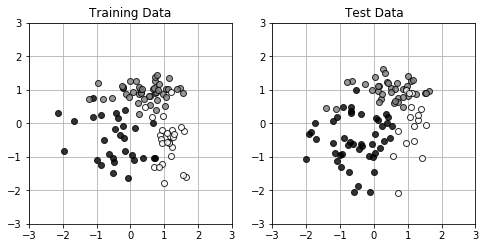

In [3]:
#-- 리스트 7-1-(3)
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터를 그리기 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none',
                 marker='o', markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [4]:
# 리스트 7-1-(4)
# 시그모이드 함수 ------------------------
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


# 네트워크 ------------------------
def FNN(wv, M, K, x):
    N, D = x.shape # 입력 차원
    w = wv[:M * (D + 1)] # 중간층 뉴런의 가중치
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):] # 출력층 뉴런의 가중치
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1)) # 중간층 뉴런의 입력 총합
    z = np.zeros((N, M + 1)) # 중간층 뉴런의 출력
    a = np.zeros((N, K)) # 출력층 뉴런의 입력 총합
    y = np.zeros((N, K)) # 출력층 뉴런의 출력
    for n in range(N):
        # 중간층의 계산
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1]) # (A)
            z[n, m] = Sigmoid(b[n, m])
        # 출력층의 계산
        z[n, M] = 1 # 더미 뉴런
        wkz = 0
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz
    return y, a, z, b

# test ---
WV = np.ones(15) # Mx(D+1)+ Kx(M+1) = 2x3+3x3 = 15, 모든 가중치를 1로 초기화
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [5]:
# 리스트 7-1-(5)
# 평균 교차 엔트로피 오차 ---------
def CE_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce


# test ---
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


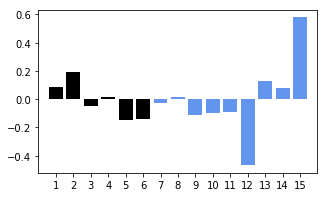

In [6]:
# 리스트 7-1-(6)
# - 수치 미분 ------------------
def dCE_FNN_num(wv, M, K, x, t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
    return dwv


#--dVW의 표시 ------------------
def Show_WV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color='black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
            align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)


#-test----
M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

In [7]:
# 리스트 7-1-(7)
import time


# 수치 미분을 사용한 구배법 -------
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n): # (A)
        wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test


# 메인 ---------------------------
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000 # (B) 학습 단계
alpha = 0.5
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:175.190 sec


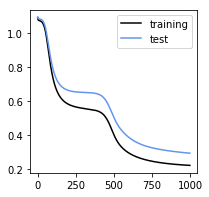

In [8]:
# 리스트 7-1-(8)
# 학습 오차의 표시 ---------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label ='test')
plt.legend()
plt.show()

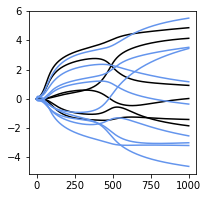

In [9]:
# 리스트 7-1-(9)
# 가중치의 시간 변화의 표시 ---------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.show()

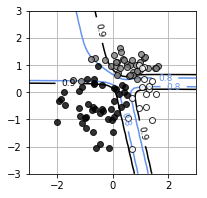

In [10]:
# 리스트 7-1-(10)
# 경계선 표시 함수 --------------------------
def show_FNN(wv, M, K):
    xn = 60 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    y, a, z, b = FNN(wv, M, K, x)
    plt.figure(1, figsize=(4, 4))
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    
    
# 경계선 표시 --------------------------
plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


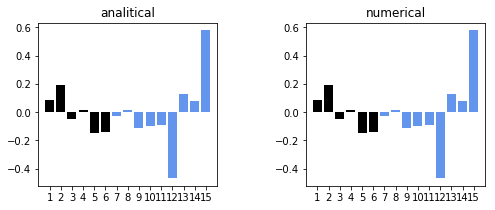

In [11]:
# 리스트 7-1-(11)
# -- 해석적 미분 -----------------------------------
def dCE_FNN(wv, M, K, x, t):  # w와 v를 업그레이드 하기 위해서 편미분값을 반환해주는 함수
    N, D = x.shape
    # wv을 w와 v로 되돌림
    w = wv[:M * (D + 1)]
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):]
    v = v.reshape((K, M + 1))  # 출력노드의 개수 K, M+1 : 히든노드 수에 1 더한 것.(바이어스)
    # ① x를 입력하여 y를 얻음
    y, a, z, b = FNN(wv, M, K, x)  # 히든노드의 입력벡터 b, 히든노드의 출력벡터 z...?? 벡터보다는 행렬에 가깝다. / y : 출력값(훈련집합?)
    # 출력 변수의 준비
    dwv = np.zeros_like(wv) # 델타 w와 델타 v를 다 구해서 합칠거임. zero_like함수 : wv의 크기로 벡터 만들어서 0으로 채운 것.
    dw = np.zeros((M, D + 1))  # dw : 델타 w(편미분값), M x (D+1) 행렬
    dv = np.zeros((K, M + 1)) 
    delta1 = np.zeros(M) # 1층 오차 (은닉층의 에러값 벡터. 우선 0으로 초기화)
    delta2 = np.zeros(K) # 2층 오차(k = 0 부분은 사용하지 않음)
    for n in range(N): # (A) 모든 훈련집합의 벡터에 대해서 돌리기(N만큼)
        # ② 출력층의 오차를 구하기 
        for k in range(K): 
            delta2[k] = (y[n, k] - t[n, k]) # 히든노드의 ...
        # ③ 중간층의 오차를 구하기
        for j in range(M):
            delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)  # 활성화함수인 시그모이드함수 미분한것 : h프라임(bj)=zj(1-zj) / dot : 내적
        # ④ v의 기울기 dv를 구하기
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N   # N으로 나누는 이유 : 트레이닝 데이터에 대해서 N으로 나누고... 계속 누적!
        # ④ w의 기울기 dw를 구하기
        for j in range(M):
            dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
    # dw와 dv를 합체시킨 dwv로 만들기  (dwv : 편미분한 값. 행벡터??)
    dwv = np.c_[dw.reshape((1, M * (D + 1))), \
                dv.reshape((1, K * (M + 1)))]
    dwv = dwv.reshape(-1)
    return dwv


#------Show WV : Weight Vector (가중치 벡터)
def Show_dWV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3],
            align="center", color='black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
            align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)
    
    
#-- 동작 확인
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)  # W벡터의 개수.(Weight Vector)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)  # 0에서 1사이의 난수 발생시켜서 WV를 초기화


dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])  # 도함수에 의해서 만들어진 편미분 값. 
print("analytical dWV")
print(dWV_ana)


dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)


plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

# 결과 그래프 2개 : "편미분값 결과가 완전히 일치한다!! 똑같은 결과의 그래프"

In [12]:
118/15

7.866666666666666

In [13]:
# 리스트 7-1-(12)
import time


# 해석적 미분을 사용한 구배법(gradient method) -------
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wv = wv_init.copy()  # wv라는 행벡터 만들기. copy...?
    err_train = np.zeros(n)  # 계산한 횟수별로 ...
    err_test = np.zeros(n)   # 제대로 트레이닝 되고 있는건지 중간에 error테스트 해보기 위해. 열벡터
    wv_hist = np.zeros((n, len(wv_init)))  # 횟수별로 wv가 어떻게 업데이트 되고있는지 저장하기 위해서 만든 벡터
    epsilon = 0.001  # 엡실론. 
    for i in range(n): 
        wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train) # (A) wv(가중치) 업데이트 / alpha : 학습률
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)   # 훈련 데이터에 대해서 교차 엔트로피 구한 것. 각각의 행벡터에 저장
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)      # 테스트 데이터에 대해서도 교차 엔트로피 구해서 저장.
        wv_hist[i, :] = wv                                  # wv도 어떻게 업데이트 되고 있는지 보여주기 위해서
    return wv, wv_hist, err_train, err_test


# 메인 ---------------------------
startTime = time.time()  # 시작시간 보여주기.
M = 2
K = 3  # 출력 노드 수
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))  # W 초기화. normal(가우시안 분포를 갖는 값들 난수로 초기화. 0~0.01 사이의 값)
N_step = 1000
alpha = 1
WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

# 한 8배 정도는 빨라진 것...

Calculation time:21.942 sec


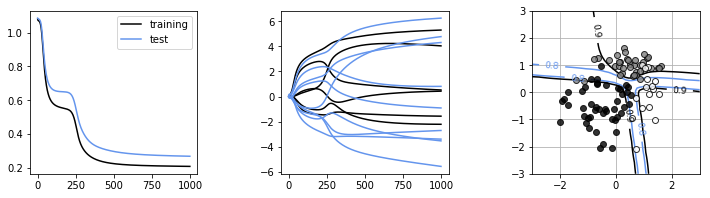

In [14]:
# 리스트 7-1-(13)
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
# 학습 오차의 표시 ---------------------------
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
# 가중치의 시간 변화 표시 ---------------------------
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
# 경계선 표시 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

# 첫번째 그래프 : 오버피팅 일어나지 않고 잘 트레이닝 되고 있다... 교차 엔트로피 이용했고...
# 두번째 그래프 : 교차 엔트로피 뭐시기....(1121 녹음 50분 이전 확인..)
# 마지막 그래프 : 최종 결과 
# 따라서 오류역전파 써야하는 이유 : 계산 시간이 8배 이상 빨라진다.

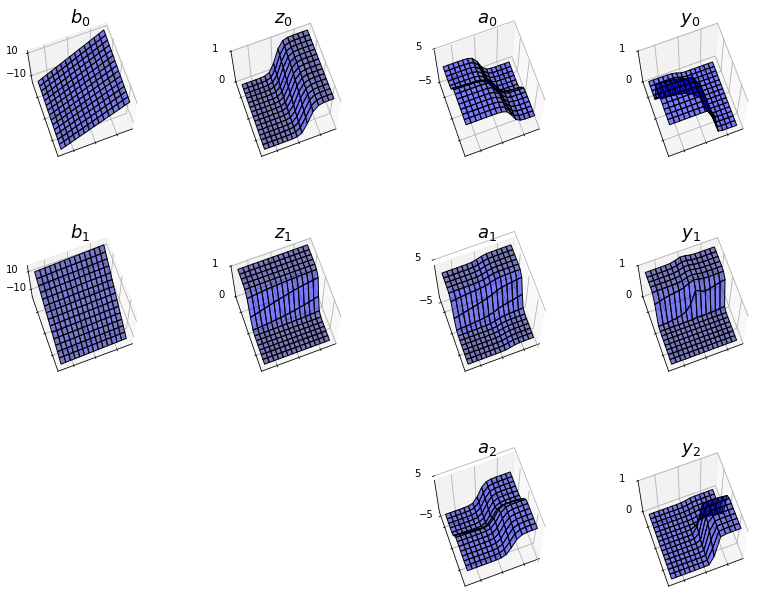

In [15]:
# 리스트 7-1-(14)
from mpl_toolkits.mplot3d import Axes3D


def show_activation3d(ax, v, v_ticks, title_str):
    f = v.copy()
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, color='blue', edgecolor='black',
                    rstride=1, cstride=1, alpha=0.5)
    ax.view_init(70, -110)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticks(v_ticks)
    ax.set_title(title_str, fontsize=18)
    
    
M = 2
K = 3
xn = 15 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y, a, z, b = FNN(WV, M, K, x)


fig = plt.figure(1, figsize=(12, 9))
plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95,
                    top=0.95, wspace=0.4, hspace=0.4)

for m in range(M):
    ax = fig.add_subplot(3, 4, 1 + m * 4, projection='3d')
    show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))
    ax = fig.add_subplot(3, 4, 2 + m * 4, projection='3d')
    show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))
    
    
for k in range(K):
    ax = fig.add_subplot(3, 4, 3 + k * 4, projection='3d')
    show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
    ax = fig.add_subplot(3, 4, 4 + k * 4, projection='3d')
    show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))


plt.show()

## 이제 딥러닝으로 넘어가기 전에, 네트워크(신경망) 구현하는데에 도움이 되는 [케라스, 텐서플로] 이용할 것!! (라이브러리를 이용해서 딥러닝 구현)

In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [23]:
# 리스트 7-2-(1)
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1) # (A)

# 케라스 관련 라이브러리 3개 기본적으로 import 해야함!
import keras.optimizers # (B) 
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)


# 데이터 로드 ---------------------------
outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

In [24]:
# 리스트 7-2-(2)
# 데이터를 그리기 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none', marker='o',
                 markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)

In [25]:
# 리스트 7-2-(3) ==> 여기부터가 구현하는 부분.
# 난수 초기화
np.random.seed(1)  # 늘 같은 결과(같은 난수) 발생시키기 위해서 난수 seed값 고정


# --- Sequential 모델 작성 ==> 네트워크 만들 준비. 셋팅.
model = Sequential()  # import한 라이브러리 중에 있는 한 객체(instance). model이라는 객체 하나 만들기. 순차적인 네트워크 만들기 위한 것.
model.add(Dense(2, input_dim=2, activation='sigmoid',  # model의 객체내용? 중에서 add라는 함수 있음. Dense라는 함수도 위에서 import했음.
                kernel_initializer='uniform')) # (A)   # Dense : 완전 연결층을 만들기 위한 객체..(함수) /  은닉층의 노드 개수 2개. input_dim : 입력층 노드 2개, 바이어스는 추가 안된 것! / 정규화분포(normal. 0~1. 가우시안) 아니고 uniform으로 초기화 하겠다!(확률값 다 같이..일정)
model.add(Dense(3,activation='softmax',                # 출력층 만드는 부분. / 3 : 출력 노드의 수 / 활성화함수로 소프트맥스 / uniform형태로 초기화
                kernel_initializer='uniform')) # (B)
sgd = keras.optimizers.SGD(lr=1, momentum=0.0,         # Ir(ir) : 학습률
                           decay=0.0, nesterov=False) # (C)
model.compile(optimizer=sgd, loss='categorical_crossentropy',  # sgd : 경사하강법 쓰겠다. / 교차 엔트로피 함수 쓰겠다. / 잘 됐는지 확인하는 용으로 accyracy(정확률)로 측정하겠다.
              metrics=['accuracy']) # (D)


# ---------- 학습
startTime = time.time()
history = model.fit(X_train, T_train, epochs=1000, batch_size=100,  # model의 fit 라는 자체 함수 호출. 트레이닝 시에는 이 fit함수 호출해서 씀.(모델 완성 후 이 함수 호출해서 써야 함)
                    verbose=0, validation_data=(X_test, T_test)) # (E) batch_size(배치) : 경사하강법 쓰겠다. / 0이면 다 끝나서 보여주고, 1이면... / 에포크인 1000마다 한번씩 보여주곘다.


# ---------- 모델 평가
score = model.evaluate(X_test, T_test, verbose=0) # (F)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'\
      .format(score[0], score[1]))
calculation_time = time.time() - startTime  # 시작시간과 끝시간 차이 구해서 계산 시간 구하기.
print("Calculation time:{0:.3f} sec".format(calculation_time))

cross entropy 0.26, accuracy 0.90
Calculation time:1.944 sec


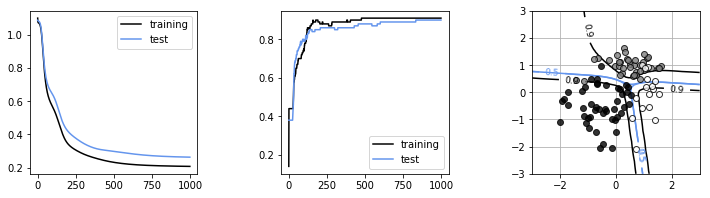

In [27]:
# 리스트 7-2-(4)
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace=0.5)


# 학습 곡선 표시 --------------------------
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label='training') # (A)
plt.plot(history.history['val_loss'], 'cornflowerblue', label='test') # (B)
plt.legend()


# 정확도 표시 --------------------------
plt.subplot(1, 3, 2)
plt.plot(history.history['acc'], 'black', label='training') # (C)
plt.plot(history.history['val_acc'], 'cornflowerblue', label='test') # (D)
plt.legend()


# 경계선 표시 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y = model.predict(x) # (E)
K = 3
for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=[
        'cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
plt.show()


# 두번째 그래프 : accuracy . 점점 1에 가까워지고 있음 ==> 잘 되고 있음..